# **Welcome to the 3D Fusion Workshop!**
Here, you will learn how to associate the bounding boxes between 2 consecutive timeframes. We're using Tracking as the main use case, but this can also be 2 different LiDARs returning boxes from 2 different viewpoints.


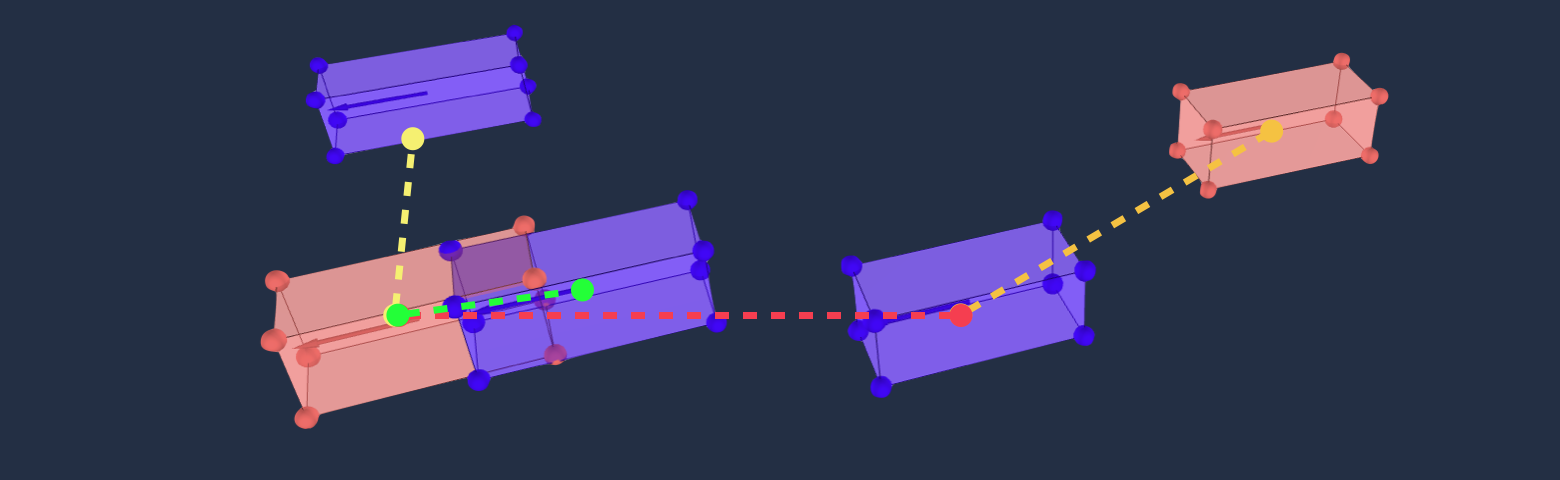

When we're working with 2D Objects, we want to match bounding boxes altogether, and we do that using the Intersection Over Union, or the appearence cost, or the bounding boxes shapes, or any other cost. I cover these in my course [MASTER OBSTACLE TRACKING](https://courses.thinkautonomous.ai/obstacle-tracking).
<p>
In 3D, we'll use several costs:

* The 3D IOU
* The Geometric Cost
* The Appearence
* The Motion Cost

## **Introduction**: Data Download & Colab Setup (5 min)

In [1]:
# !wget https://thinkautonomous-3d-tracking.s3.us-west-2.amazonaws.com/viewer.zip && unzip -q viewer.zip
# !wget https://thinkautonomous-3d-tracking.s3.us-west-2.amazonaws.com/data.zip && unzip -q data.zip
# !wget https://thinkautonomous-3d-tracking.s3.us-west-2.amazonaws.com/multi_object_tracking.zip && unzip -q multi_object_tracking.zip

# !mv data multi_object_tracking/data
# !mv viewer multi_object_tracking/viewer

In [2]:
# !pip install open3d #will be used later
# !pip install rerun-sdk[notebook]==0.22.1
# !pip install numpy==1.23.5
# !pip install scipy==1.14.1

**HERE, RESTART THE SESSION with RUNTIME> RESTART SESSION** <p>
You won't need to re-run the previous cells.

### Imports

In [3]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

import rerun as rr  # pip install rerun-sdk
import rerun.blueprint as rrb
from scipy.spatial.transform import Rotation as R

sys.path.append("4d-dataset/")
sys.path.append("4d-dataset/multi_object_tracking/")

In [4]:
from multi_object_tracking.dataset.kitti_data_base import velo_to_cam, read_pose, read_calib, read_velodyne, read_image, cam_to_velo
import re

## **Part 1**: Load & Visualize Sequences & Point Clouds


**Note:** In this notebook, we won't use any object detector, but directly the label, so we create a very similar dataset function, but we skip the DatasetTemplate, and we don't return a dictionnary (it was needed for Point-RCNN but not anymore).

In [5]:
class KittiDetectionDataset:
    def __init__(self,root_path,seq_id, label_path = None):
        self.seq_name = str(seq_id).zfill(4)
        self.root_path = root_path
        self.velo_path = os.path.join(self.root_path,"velodyne", self.seq_name)
        self.image_path = os.path.join(self.root_path,"image_02", self.seq_name)
        self.calib_path = os.path.join(self.root_path,"calib")
        self.label_path = label_path
        pose_path = os.path.join(self.root_path, "pose", self.seq_name,'pose.txt')
        self.poses = read_pose(pose_path)

    def __len__(self):
        return len(os.listdir(self.velo_path))

    def __getitem__(self, item):
        input_dict = {}
        name = str(item).zfill(6)
        velo_path = os.path.join(self.velo_path,name+'.bin')
        image_path = os.path.join(self.image_path, name+'.png')
        calib_path = os.path.join(self.calib_path, self.seq_name+'.txt')

        input_dict["frame_id"] = item

        pose = self.poses[item] if item in self.poses.keys() else None;
        input_dict["pose"] = pose

        P2,V2C = read_calib(calib_path)
        input_dict["P2"] = P2
        input_dict["V2C"] = V2C

        points = read_velodyne(velo_path,P2,V2C)
        input_dict["points"] = points

        image = read_image(image_path)
        input_dict["image"] = image

        objects, objects_cam, det_scores, det_names = [], [], [], []

        if self.label_path is not None:
            # If we have a label path, we'll read the labels instead of predicting them
            label_path = os.path.join(self.label_path, self.seq_name, name+'.txt')
            objects, det_scores, det_names = self.read_detection_label(label_path)
        if len(objects)>0:
            objects_cam = np.copy(objects)
            objects[:,3:6] = cam_to_velo(objects[:,3:6],V2C)[:,:3]
        input_dict["objects"] = objects
        input_dict["objects_cam"] = objects_cam
        input_dict["scores"] = det_scores
        input_dict["names"] = det_names

        return input_dict

    def read_detection_label(self,label_path):
        objects_list = []
        det_scores = []
        det_names = []
        with open(label_path) as f:
            for each_ob in f.readlines():
                infos = re.split(' ', each_ob)
                if infos[0] in ['Car', 'Truck','Van', 'Cyclist']:
                    objects_list.append(infos[8:15])
                    det_scores.append(infos[15])
                    det_names.append(infos[0])
        return np.array(objects_list, np.float32), np.array(det_scores, np.float32), det_names

We're now going to create a **Dataset** object that will have these values:
* P2: The intrinsic camera calibration matrix
* V2C: The Velodyne (LiDAR) to Camera projection matrix
* Points: The Point Cloud
* Image: The Image
* Objects: The 3D Bounding Boxes
* Scores: The Scores

Because we "need" a label, we'll load one from the *multi_object_tracking/detector* folder, please disregard this for now as it is not used.

In [6]:
root = "4d-dataset/data/data/"
label_path = "4d-dataset/multi_object_tracking/multi_object_tracking/detectors/point_rcnn"
dataset = KittiDetectionDataset(root,seq_id=8,label_path=label_path)
dataset[0]  # Access the first item

{'frame_id': 0,
 'pose': array([[ 1.00000000e+00, -3.88130018e-18, -1.41550000e-18,
         -4.65660011e-10],
        [-4.42190010e-17,  1.00000000e+00,  2.12350002e-18,
          1.16419999e-10],
        [ 1.82910003e-18,  2.12809997e-18,  1.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 'P2': array([[7.215377e+02, 0.000000e+00, 6.095593e+02, 4.485728e+01],
        [0.000000e+00, 7.215377e+02, 1.728540e+02, 2.163791e-01],
        [0.000000e+00, 0.000000e+00, 1.000000e+00, 2.745884e-03]],
       dtype=float32),
 'V2C': array([[ 2.34773604e-04, -9.99944129e-01, -1.05634776e-02,
         -2.79681677e-03],
        [ 1.04494081e-02,  1.05653538e-02, -9.99889606e-01,
         -7.51087910e-02],
        [ 9.99945368e-01,  1.24365346e-04,  1.04513032e-02,
         -2.72132808e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 'points': array([[ 7.47229996e+01,  2.12

**First, visualize the images alone**

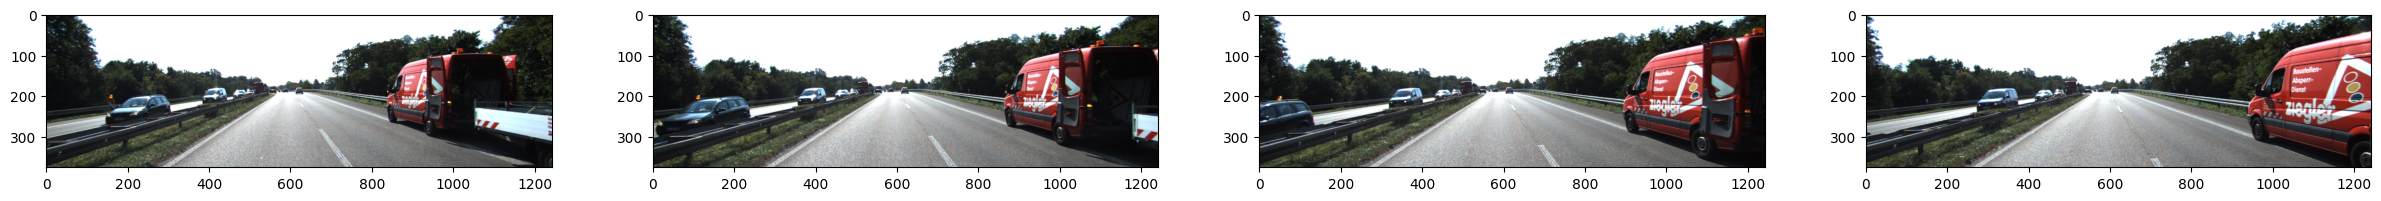

In [7]:
def view_images(images_to_be_shown):
  _, axs = plt.subplots(1, len(images_to_be_shown), figsize=(30, 30))

  if len(images_to_be_shown)> 1:
    axs = axs.flatten()
    for img, ax in zip(images_to_be_shown, axs):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  else:
        axs.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

  plt.show()


hand_picked_frames = [0,1,2,3]
images_2d = [dataset[i]["image"] for i in hand_picked_frames]

view_images(images_2d)

In [8]:
### Just visualize Raw Data
hand_picked_frames = [0,1]

In [9]:
print(dataset[0].keys())

dict_keys(['frame_id', 'pose', 'P2', 'V2C', 'points', 'image', 'objects', 'objects_cam', 'scores', 'names'])


Now the visualization loop. You can find ideas for colormap [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

In [10]:
def project_3d_box_to_image(bbox_3d, P2):
    h, w, l, x, y, z, ry = bbox_3d
    x_corners = [ l/2,  l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2 ]
    y_corners = [  0,    0,    0,    0,   -h,   -h,   -h,   -h ]
    z_corners = [ w/2, -w/2, -w/2,  w/2,  w/2, -w/2, -w/2,  w/2 ]

    corners_3d = np.vstack([x_corners, y_corners, z_corners])
    R_y = np.array([
        [ np.cos(ry), 0, np.sin(ry)],
        [         0, 1,         0],
        [-np.sin(ry), 0, np.cos(ry)]
    ])
    corners_3d = R_y @ corners_3d + np.array([[x], [y], [z]])
    corners_3d_hom = np.vstack((corners_3d, np.ones((1, 8))))
    corners_2d = P2 @ corners_3d_hom
    corners_2d = corners_2d[:2] / corners_2d[2]
    return corners_2d.T

#### Convert ego car model and rotate it

In [11]:
# export the ego car model to glb format compatible with rerun
# and rotate it to align with the rerun viewer
# !sudo apt-get install assimp-utils # after install, restart the kernel
# !assimp export 4d-dataset/viewer/ego_car.3ds 4d-dataset/viewer/ego_car.glb 

import trimesh

mesh = trimesh.load("4d-dataset/viewer/ego_car.glb")
# Rotate -90 around X, 180 around Z
import numpy as np
R_x = trimesh.transformations.rotation_matrix(np.radians(90), [1, 0, 0])
T = trimesh.transformations.translation_matrix([0, 0, -3])
mesh.apply_transform(R_x)
mesh.apply_transform(T)
mesh.export("4d-dataset/viewer/ego_car_fixed.glb")

b'glTF\x02\x00\x00\x00\xec\x8d\x10\x00\xf0\xe0\x02\x00JSON{"scene":0,"scenes":[{"nodes":[0]}],"asset":{"version":"2.0","generator":"https://github.com/mikedh/trimesh"},"accessors":[{"componentType":5125,"type":"SCALAR","bufferView":0,"count":432,"max":[147],"min":[0]},{"componentType":5126,"type":"VEC3","byteOffset":0,"bufferView":1,"count":148,"max":[0.33350858092308044,0.33350858092308044,0.0296173095703125],"min":[-0.33350861072540283,-0.33350858092308044,-0.0296175479888916]},{"componentType":5126,"type":"VEC2","byteOffset":0,"bufferView":2,"count":148,"max":[1.0,1.0],"min":[0.0,0.0]},{"componentType":5126,"count":148,"type":"VEC3","byteOffset":0,"bufferView":3,"max":[0.25742995738983154,0.25742998719215393,1.0],"min":[-0.25742995738983154,-0.25742998719215393,-1.0]},{"componentType":5126,"type":"VEC3","byteOffset":0,"bufferView":4,"count":148,"max":[0.32009634375572205,0.32009634375572205,0.1640610694885254],"min":[-0.32009637355804443,-0.32009634375572205,-0.1640610694885254]},{"

In [12]:
def visualize(dataset, frames=None, output_path=None, score_threshold=3, viz_labels=False):
    rr.init("KITTI Visualizer 1243805", spawn=False)

    blueprint = rrb.Blueprint(
        rrb.Horizontal(
            rrb.Spatial2DView(origin="world/ego_vehicle/camera", name="Camera"),
            rrb.Spatial3DView(origin="world/ego_vehicle/lidar", name="LiDAR"),
            column_shares=[1, 1]
        )
    )

    # rr.send_blueprint(blueprint)  # force the vertical layout to take effect

    rr.log("world/ego_vehicle/camera/", rr.ViewCoordinates.RIGHT_HAND_Y_DOWN)
    rr.log("world/ego_vehicle/lidar/", rr.ViewCoordinates.RIGHT_HAND_Z_UP)

    if frames is None:
        frames = list(range(len(dataset)))

    for i in frames:
        rr.set_time_sequence("frame", i)
        rr.log("world/ego_vehicle/camera/image/detections", rr.Clear(recursive=True))
        rr.log("world/ego_vehicle/lidar/points", rr.Clear(recursive=False))
        rr.log("world/ego_vehicle/lidar/objects", rr.Clear(recursive=True))

        data = dataset[i]
        image = np.array(data['image'])
        points = data['points']
        P2, V2C = data['P2'], data['V2C']
        pose = data['pose']

        if pose is not None:
            translation = pose[:3, 3]
            rotation_matrix = pose[:3, :3]
            r = R.from_matrix(rotation_matrix)
            quat_xyzw = r.as_quat()  # scipy returns [x, y, z, w]

            # rr.log("world/ego_vehicle", rr.Transform3D(
            #     translation=translation,
            #     quaternion=rr.Quaternion(xyzw=quat_xyzw),
            #     relation=rr.TransformRelation.ParentFromChild,
            # ))

            # ===== ADD EGO VEHICLE MODEL =====
            rr.log(
                "world/ego_vehicle/car_model",
                rr.Asset3D(
                    path="4d-dataset/viewer/ego_car_fixed.glb",  # Path to your GLB file
                    albedo_factor = [0.6, 0.6, 0.6]
                )
            )

        rr.log("world/ego_vehicle/camera/image", rr.Image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

        positions = points[:, :3]
        colors = (plt.cm.cividis(np.linspace(0, 1, len(positions)))[:, :3] * 255).astype(np.uint8)  # Use a colormap for colors
        rr.log("world/ego_vehicle/lidar/points", rr.Points3D(positions=positions, colors=colors))

        if viz_labels:
            for j, (box, box_cam, score, name) in enumerate(zip(data['objects'], data['objects_cam'], data['scores'], data['names'])):
                if score < score_threshold:
                    continue

                color = [
                    random.randint(0, 255),  # R
                    random.randint(0, 255),  # G
                    random.randint(0, 255),  # B
                    180  # Alpha (semi-transparent)
                    ]

                # 3D Camera Boxes
                corners_2d = project_3d_box_to_image(box_cam,P2)
                edges = [
                    [0, 1], [1, 2], [2, 3], [3, 0],
                    [4, 5], [5, 6], [6, 7], [7, 4],
                    [0, 4], [1, 5], [2, 6], [3, 7]
                ]
                lines = [np.array([corners_2d[start], corners_2d[end]]) for start, end in edges]

                rr.log(f"world/ego_vehicle/camera/image/detections/box_{j}", rr.LineStrips2D(lines, labels=[f"{name} {score:.2f}"], colors=np.array([color])))

                # 3D Lidar boxes
                h, w, l, x, y, z, ry = box
                # Convert KITTI rotation to Rerun coordinate system
                yaw = -ry - np.pi / 2
                center = np.array([x, y, z + h / 2])
                size = np.array([l, w, h])

                # Create quaternion for rotation around Z-axis in Rerun's coordinate system
                quat = R.from_euler('z', yaw, degrees=False).as_quat()
                # Rerun expects [w, x, y, z] format
                quat = np.array([quat[0], quat[1], quat[2], quat[3]])

                rr.log(f"world/ego_vehicle/lidar/objects/box_{j}", rr.Transform3D(
                    translation=center,
                    quaternion=rr.Quaternion(xyzw=quat),
                    relation=rr.TransformRelation.ParentFromChild,
                ))

                rr.log(f"world/ego_vehicle/lidar/objects/box_{j}/model", rr.Asset3D(
                    path="4d-dataset/viewer/car.obj",
                    albedo_factor=np.array(color[:3]) / 255.0
                ))
    # Save and display
    rr.notebook_show(height=700, width=1300)

hand_picked_frames = range(250,260)
# Visualize the LiDAR point cloud and 2d Image in a video sequence with labels
visualize(dataset, frames=hand_picked_frames, output_path="output/output_ego.rerun", viz_labels=True)

Viewer()

Earlier in the notebook, we called this function:
```python
root = "multi_object_tracking/data"
label_path = "multi_object_tracking/detectors/point_rcnn"
dataset = KittiDetectionDataset(root,seq_id=8,label_path=label_path)
```
You can keep "Point-RCNN" as the label algorithm, or change to another one.

In [12]:
'''
# TODO: Explore the 4 Algorithms and pick the one that is the most state-of-the-art.
# Then use this algorithm as the main algorithm.
'''
label_path = "4d-dataset/multi_object_tracking/multi_object_tracking/detectors/point_rcnn"
label_dir = "4d-dataset/multi_object_tracking/multi_object_tracking/detectors/second_iou/0008"
dataset = KittiDetectionDataset(root,seq_id=8,label_path=label_path)

In [15]:
## Let us inspect what's inside one sample in dataset
def print_dataset_item(dataset, index):
    print(f"The dataset contains a total of {len(dataset)} samples.")
    item = dataset[index]

    # Unpack keys into variables
    frame_id = item['frame_id']
    pose = item['pose']
    P2 = item['P2']
    V2C = item['V2C']
    points = item['points']
    image = item['image']
    objects = item['objects']
    objects_cam = item['objects_cam']
    det_scores = item['scores']
    label_names = item['names']

    # Print shapes and sample data
    print(f"Index: {index}")
    print(f"frame_id: {frame_id}")
    print(f"pose shape: {pose.shape}")
    print(f"P2 shape: {P2.shape}")
    print(f"V2C shape: {V2C.shape}")
    print(f"points shape: {points.shape}, dtype: {points.dtype}")
    print(f"image shape: {image.shape}, dtype: {image.dtype}")
    print(f"objects shape: {objects.shape}")
    print(f"objects_cam shape: {objects_cam.shape}")
    print(f"det_scores shape: {det_scores.shape}")
    print(f"label_names (sample): {label_names[:2]}")

hand_picked_frames = [0, 1]
print_dataset_item(dataset, hand_picked_frames[0])

The dataset contains a total of 390 samples.
Index: 0
frame_id: 0
pose shape: (4, 4)
P2 shape: (3, 4)
V2C shape: (4, 4)
points shape: (18867, 4), dtype: float64
image shape: (375, 1242, 3), dtype: uint8
objects shape: (10, 7)
objects_cam shape: (10, 7)
det_scores shape: (10,)
label_names (sample): ['Car', 'Car']


When we called dataset, we did it this way:
```python
for i in hand_picked_frames:
    P2, V2C, points, image, labels, scores = dataset[i]
```
Which means that for any instance of **dataset**, we have:
* P2 — a camera matrix
* V2C — a matrix to go from Velodyne LiDAR to Camera
* Point — the point cloud
* Image — the image
* Labels — the bounding boxes
* Scores — the scores

**So let's print the objects and their scores**

In [16]:
print(len(dataset[hand_picked_frames[0]]['objects']))
print(len(dataset[hand_picked_frames[0]]['scores']))

10
10


We have 10 detected boundin boxes! Isn't this a lot?
Let's look at the image again:

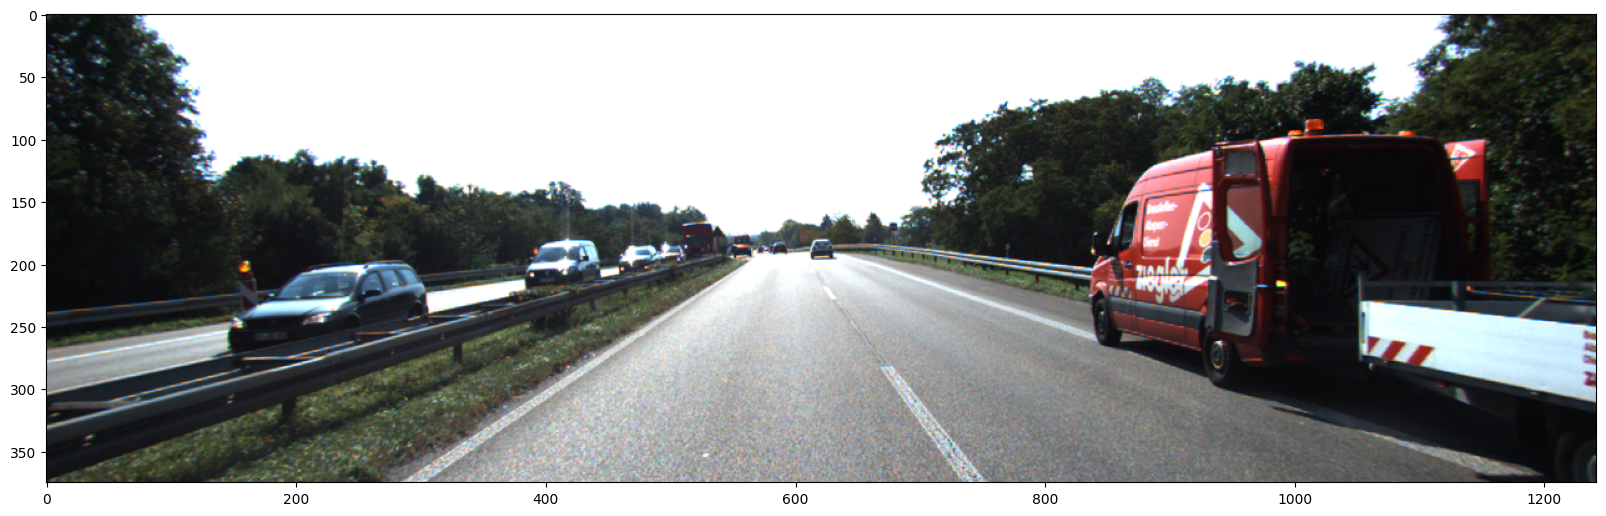

In [17]:
def view_images(images_to_be_shown):
    fig, axs = plt.subplots(1, len(images_to_be_shown), figsize=(20, 10))
    if len(images_to_be_shown) > 1:
        for ax, img in zip(axs, images_to_be_shown):
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        img = images_to_be_shown[0]
        axs.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

hand_picked_frames = [0]
images_2d = [dataset[i]["image"] for i in hand_picked_frames]

view_images(images_2d)

With my humble human abilities, I only see about 4 or 5 obstacles. Let's print the scores of the boxes and filter those who are too low:

In [18]:
hand_picked_frames=[0,1]

In [19]:
print(dataset[hand_picked_frames[0]]['scores'])

[12.3169  9.7748  4.7599  2.9728  1.7072  0.4846 -0.113  -0.4252 -1.315
 -2.1597]


In [22]:
def filter_boxes(dataset_item, thresh=1):
    # for every frame, get the boxes, scores, and filter the boxes with a low (0-1) score
    obj = dataset_item['objects']
    obj_cam = dataset_item['objects_cam']
    sco = dataset_item['scores']
    return obj[sco>thresh], obj_cam[sco>thresh]

**Ok let's use some variables**

## **Part 2**: Associate Bounding Boxes from 2 Consecutive Frames

### 3D Visualization on the same frame

**First, let's simply visualize the boxes from t-1 and t in the same 3D frame. Because we became so good with 3D Visualization, let's show 3D only.**

In [ ]:
boxes_t0_cam_unfiltered = dataset[hand_picked_frames[0]]['objects_cam']
boxes_t1_cam_unfiltered = dataset[hand_picked_frames[1]]['objects_cam']

boxes_t0, boxes_t0_cam = filter_boxes(dataset[hand_picked_frames[0]])
boxes_t1, boxes_t1_cam = filter_boxes(dataset[hand_picked_frames[1]])

print("----")
print(f"The number of 3D boxes in first index (unfiltered) are: {len(boxes_t0_cam_unfiltered)}")
print(f"The number of 3D boxes in first index are: {len(boxes_t0)}")
print("----")
print(f"The number of 3D boxes in second index (unfiltered) are: {len(boxes_t1_cam_unfiltered)}")
print(f"The number of 3D boxes in second index are: {len(boxes_t1)}")
print("----")

In [29]:
print(boxes_t0.shape)
print(boxes_t0[0])
print(boxes_t1[0])

(5, 7)
[ 1.5005     1.6285     4.1865    16.425442   8.308184  -1.9274065
  1.5404   ]
[ 1.523      1.619      4.1001    13.315202   8.282779  -1.9204743
  1.5316   ]


**Visualize t-1 and t point cloud detections in single frame**

In [48]:
# Initialize recording
rr.init("Rerun KITTI Viz - Single Scene", recording_id="boxes_overlay")

# Define 3D view
rr_blueprint = rr.blueprint.Blueprint(
    rr.blueprint.Spatial3DView(origin="world/lidar", name="LiDAR View")
)
rr.send_blueprint(rr_blueprint)

# Log the point cloud (T0)
positions_t0 = dataset[0]["points"][:,:3]
rr.log("world/lidar/points_t0", rr.Points3D(
    positions=positions_t0,
    colors=[0, 180, 0] , # dark red
))

# Log the point cloud (T1)
positions_t1 = dataset[1]["points"][:,:3]
rr.log("world/lidar/points_t1", rr.Points3D(
    positions=positions_t1,
    colors=[255, 0, 0],  # light red
))

# Helper to log boxes
def log_boxes(boxes, color_rgb, prefix):
    """
    boxes: Nx7 array [h, w, l, x, y, z, ry]
    color_rgb: tuple of 3 ints (0-255)
    prefix: str, e.g., 'boxes_t0'
    """
    for i, box in enumerate(boxes):
        h, w, l, x, y, z, ry = box
        yaw = -ry - np.pi / 2
        center = np.array([x, y, z + h/2])
        size = np.array([l, w, h])
        quat = R.from_euler('z', yaw).as_quat()

        obj_path = f"world/lidar/{prefix}/box_{i}"

        rr.log(obj_path, rr.Boxes3D(
            centers=center[None],
            half_sizes=size[None]/2,
            rotations=[rr.Quaternion(xyzw=quat)],
            colors=np.array(color_rgb)[None]
        ))


# Log blue boxes (Frame 0 - t0)
log_boxes(boxes_t0, color_rgb=[0, 180, 0], prefix="frame0")

# Log red boxes (Frame 1 - t1)
log_boxes(boxes_t1, color_rgb=[255, 0, 0], prefix="frame1")

# Show in notebook
rr.notebook_show(height=500, width=1000)

Viewer()

### **3D Association**
If we print the values for a single bounding box, we get:


In [38]:
print(f"The h, w, l, x, y, z and yaw values are {boxes_t0[0]}")

The h, w, l, x, y, z and yaw values are [ 1.5005     1.6285     4.1865    16.425442   8.308184  -1.9274065
  1.5404   ]


**These coordinates represent: H, W, L, X, Y, Z, ϴ** (with these 7 values, we can do a 3D Bounding Box). At every frame, this is what we get, so let's see how to process that from frame to frame.<p>

We are going to explore 4 techniques:
* Centroid Distance
* Orientation Loss
* Chamfer Loss
* 3D IOU
<p>Also:
* A fifth technique involving deep 3D convolutional feature matching will be explained in the course, but not implemented in this notebook as we're only loading the labels.

**Warning** The KITTI Dataset "Z" value isn't the center of the bounding box, but the bottom, we'd therefore need to convert it to the center to make our next calculations better:

In [40]:
print(boxes_t0)                       # Prints the full array of boxes (h, w, l, x, y, z, yaw)
print()
print(boxes_t0[:,5])                  # prints depth values (z) usually bottom center of box
print(boxes_t0[:,2])                  # prints h height values
print(boxes_t0[:,5]+boxes_t0[:,2]/2)  # Adds half height to box z value, so that it becomes center of the box z.

[[ 1.5005     1.6285     4.1865    16.425442   8.308184  -1.9274065
   1.5404   ]
 [ 1.6983     1.706      4.2326    31.574121   8.501713  -1.791252
   1.5558   ]
 [ 1.4751     1.5792     3.6608    62.091747   9.196064  -1.8241286
   1.5422   ]
 [ 1.5088     1.6009     3.8044    37.944824   5.3804665 -1.5008271
   1.5725   ]
 [ 1.4808     1.6534     4.3063    28.802952  17.906185  -2.1980925
   1.5682   ]]

[-1.9274065 -1.791252  -1.8241286 -1.5008271 -2.1980925]
[4.1865 4.2326 3.6608 3.8044 4.3063]
[ 0.16584349  0.3250481   0.00627136  0.4013729  -0.04494238]


In [41]:
def change_box_format(boxes):   # bottom center of box to middle center of box
    new_boxes = boxes
    new_boxes[:,5] += boxes[:,0]/2
    return new_boxes

In [42]:
boxes_t0 = change_box_format(boxes_t0)
boxes_t1 = change_box_format(boxes_t1)

#### **1. Centroid Loss**
We'll start by doing a dead-simple euclidean distance between the Centroids.
* **Advantages**: It's fast, simple, and it can work because of 3D volumes.
* **Drawbacks**: It won't work in crowded places, and you'll need to set a manual threshold to remove long distance associations.

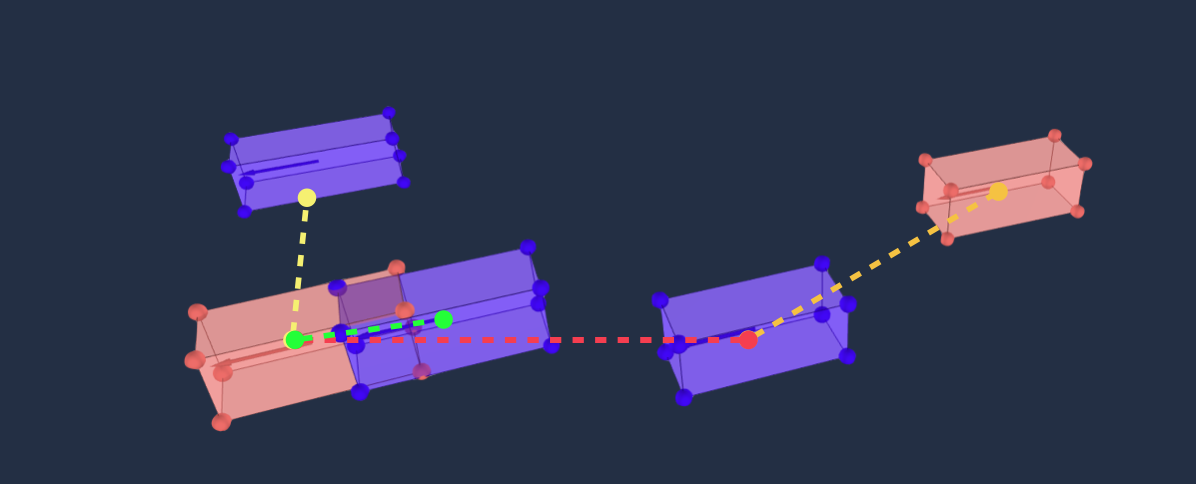

In [54]:
box1_t0 = boxes_t0[0]
box1_t1 = boxes_t1[0]

print(box1_t0)
print(box1_t1)

[ 1.5005     1.6285     4.1865    16.425442   8.308184  -1.1771566
  1.5404   ]
[ 1.523      1.619      4.1001    13.315202   8.282779  -1.1589743
  1.5316   ]


In [49]:
def centroid_loss(centroid1=None, centroid2=None):
    return np.linalg.norm(centroid1-centroid2)
    

In [56]:
print(box1_t0[3:6])
print(box1_t1[3:6])

[16.425442   8.308184  -1.1771566]
[13.315202   8.282779  -1.1589743]


In [57]:
print(centroid_loss(box1_t0[3:6], box1_t1[3:6]))    # x,y, z

3.1103969


Now imagine I do something crazy, the value increases.

In [59]:
box2_t0 = boxes_t0[2]
print(centroid_loss(box1_t0[3:6], box2_t0[3:6]))

45.675026


**In 3D, we shouldn't need anything else.** <p>If your 3D projections are correct, there will be no overlap. If we have no overlap, why computing an IOU score? Why doing an orientation error? Why doing a Deep Distance?<p>

My take is, it's not needed, but it could be if a pedestrian is super close to a parked car, and somehow the distance from pedestrian to car is inferior than the distance from car to car.<p>

So let's see the other types of association

#### **2. Orientation Loss**
What if 2 cars are crossing eachother, driving super close, but driving in opposite directions? We can remove that use case using an orientation loss.

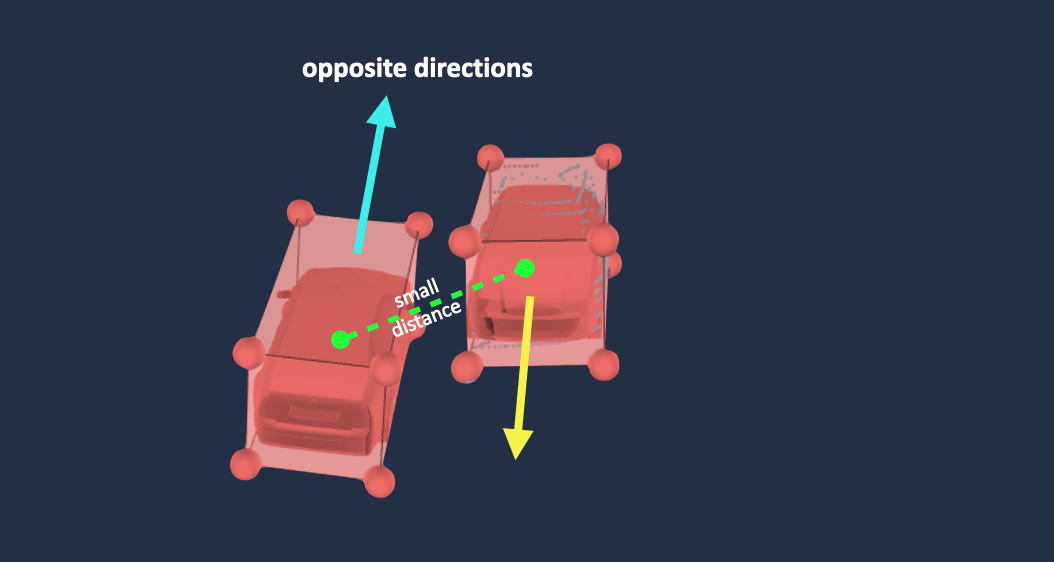

In [66]:
import math

def orientation_loss(orientation1=None, orientation2=None):
    return float(1-math.cos(orientation1 - orientation2))

In [ ]:
print(box1_t0[6])
print(box1_t1[6])
print(orientation_loss(box1_t0[6], box1_t1[6]))

1.5404
1.5316
3.872001196547625e-05


Same, now let's do something crazy and look at the loss increasing.

In [67]:
print(orientation_loss(box1_t0[6], 180))

1.8189707276183507


These 2 losses can work together. We can build a function that does something like:
```python
total_loss = loss_centroid + loss_orientation
```
After all, why not doing it?

#### **3.Chamfer Loss**
The Chamfer Loss gives the distance between two point clouds. It's heavily used in 3D Reconstruction and Point Cloud Alignnment tasks in SLAM. We'll see how it works in Tracking here.
Here's how:
1. We'll grab the points inside each of the boxes
2. We'll run the Chamfer loss over the two point clouds

**If the points structure is the same, then the Chamfer Loss will be small.** If we have a pedestrian and a car, then the loss will increase.

Let's see:

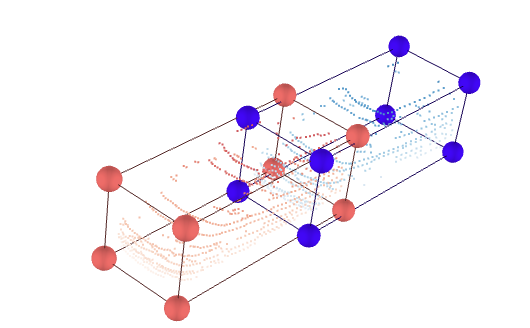

In [68]:
boxes_t0_original = dataset[hand_picked_frames[0]]['objects']
boxes_t1_original = dataset[hand_picked_frames[1]]['objects']

points_t0 = dataset[hand_picked_frames[0]]['points']
points_t1 = dataset[hand_picked_frames[1]]['points']

**1. Filter the points inside the box**


In [69]:
print("Box Properties are H W L X Y Z Yaw")
print(boxes_t0[0])

Box Properties are H W L X Y Z Yaw
[ 1.5005     1.6285     4.1865    16.425442   8.308184  -1.1771566
  1.5404   ]


In [71]:
def get_bounding(box):
    h, w, l, x, y, z, theta  = box
    x_max = x + l /2
    y_max = y + w /2
    z_max = z + h /2
    x_min = x - l /2
    y_min = y - w /2
    z_min = z - h /2
    return [x_min, y_min, z_min, x_max, y_max, z_max]

In [72]:
print("Box Properties are H W L X Y Z T")
print(boxes_t0)
print(" ")
print("New Properties of first box are X1 Y1 Z1 X2 Y2 Z2")
print(get_bounding(boxes_t0[0]))

Box Properties are H W L X Y Z T
[[ 1.5005      1.6285      4.1865     16.425442    8.308184   -1.1771566
   1.5404    ]
 [ 1.6983      1.706       4.2326     31.574121    8.501713   -0.942102
   1.5558    ]
 [ 1.4751      1.5792      3.6608     62.091747    9.196064   -1.0865786
   1.5422    ]
 [ 1.5088      1.6009      3.8044     37.944824    5.3804665  -0.74642706
   1.5725    ]
 [ 1.4808      1.6534      4.3063     28.802952   17.906185   -1.4576924
   1.5682    ]]
 
New Properties of first box are X1 Y1 Z1 X2 Y2 Z2
[14.332191705703735, 7.49393367767334, -1.9274065494537354, 18.518691778182983, 9.12243366241455, -0.4269065856933594]


In [73]:
from scipy.spatial import cKDTree

def points_inside_boxes(points, boxes):
    # Use a KDTree to get points inside boxes
    box_points = []
    tree = cKDTree(points)

    for box in boxes:
        x_min, y_min, z_min, x_max, y_max, z_max = get_bounding(box)

        # Compute center and radius
        center = [(x_min + x_max)/2, (y_min + y_max)/2, (z_min + z_max)/2]
        size = np.array([x_max - x_min, y_max - y_min, z_max - z_min])
        radius = np.linalg.norm(size) / 2

        # Get nearby point indices using KDTree
        indices = tree.query_ball_point(center, r=radius)

        # Filter those inside box
        inside = []
        for i in indices:
            if (points[i] >= [x_min, y_min, z_min]).all() and (points[i] <= [x_max, y_max, z_max]).all():
                inside.append(i)

        box_points.append(points[inside])

    return box_points

In [74]:
points_inside_boxes_t0 = points_inside_boxes(points_t0[:, :3], boxes_t0)
print([len(p) for p in points_inside_boxes_t0])

[419, 109, 18, 13, 25]


In [76]:
points_inside_boxes_t1 = points_inside_boxes(points_t1[:,:3], boxes_t1)
print([len(p) for p in points_inside_boxes_t1])

[674, 152, 20, 9, 14]


**2. Run our chamfer distance**

In [85]:
import open3d as o3d

def chamfer_distance_open3d(pts0, pts1):
    # Use Open3D to compute the Chamfer Distance between the 2 clouds
    pcd0 = o3d.geometry.PointCloud()
    pcd0.points = o3d.utility.Vector3dVector(pts0)
    pcd1 = o3d.geometry.PointCloud()
    pcd1.points = o3d.utility.Vector3dVector(pts1)

    return pcd0.compute_point_cloud_distance(pcd1)

dists = chamfer_distance_open3d(points_inside_boxes_t0[0], points_inside_boxes_t1[0])
print("Distance:" , sum(dists))

Distance: 420.3978409465405


**3. Compare Visually**

In [88]:
all_pts0 = np.concatenate(points_inside_boxes_t0, axis=0)
all_pts1 = np.concatenate(points_inside_boxes_t1, axis=0)

print(len(all_pts0))
print(len(all_pts1))

584
869


In [91]:
points = dataset[hand_picked_frames[0]]['points']
image = dataset[hand_picked_frames[0]]['image']
V2C = dataset[hand_picked_frames[0]]['V2C']
P2 = dataset[hand_picked_frames[0]]['P2']

In [92]:
print(len(all_pts0))
print("---")
print(len(points))

584
---
18867


In [94]:
# Initialize Rerun
rr.init("KITTI Merged Visualization", recording_id="merged_run", spawn=False)

# Layout: side by side views
blueprint = rrb.Blueprint(
    rrb.Horizontal(
        rrb.Spatial3DView(origin="world/ego_vehicle/lidar", name="3D View"),
        column_shares=[1,1]
    )
)

rr.send_blueprint(blueprint)

# Coordinate conventions
rr.log("world/ego_vehicle/lidar/", rr.ViewCoordinates.RIGHT_HAND_Z_UP)

data = dataset[hand_picked_frames[0]]
image = np.array(data['image'])

# Log blue points (frame 0)
rr.log("world/ego_vehicle/lidar/frame0/points", rr.Points3D(
    positions=all_pts0,
    colors=np.full((all_pts0.shape[0], 3), [180, 210, 250], dtype=np.uint8)
))

# Log red points (frame 1)
rr.log("world/ego_vehicle/lidar/frame1/points", rr.Points3D(
    positions=all_pts1,
    colors=np.full((all_pts1.shape[0], 3), [228, 50, 50], dtype=np.uint8)
))


def log_3d_box(bbox_3d, idx, frame_label, color_rgb):
    h, w, l, x, y, z, ry = bbox_3d
    yaw = -ry - np.pi/2
    center = np.array([x, y, z])
    quat = R.from_euler('z', yaw, degrees=False).as_quat()

    rr.log(
        f"world/ego_vehicle/lidar/{frame_label}/box_{idx}",
        rr.Boxes3D(
            centers=center[None],
            half_sizes=np.array([[l/2, w/2, h/2]]),
            rotations=[rr.Quaternion(xyzw=quat)],
            colors=np.array(color_rgb, dtype=np.uint8)[None]
        )
    )

# Frame 0 3D boxes
for idx, box_lidar in enumerate(boxes_t0):
    log_3d_box(box_lidar, idx, "frame0", [180, 210, 250])

# Frame 1 3D boxes
for idx, box_lidar in enumerate(boxes_t1):
    log_3d_box(box_lidar, idx, "frame1", [228,50,50])

# Show viewer
rr.notebook_show(height=500, width=1000)

Viewer()

#### **Get the Total Geometric Cost**

In [ ]:
def geometric_cost(box1, box2, w1=1,w2=1,w3=1):
    return w1*euclidean_distance(box1, box2) + w2*orientation_distance(box1,box2) + w3*chamfer_distance(box1, box2)

#### **4. 3D IOU**
In 2D, the most common metric ever for tracking or fusion is the Intersection Over Union. Although this is a good enough metric in 2D (and I would argue it's definitely not enough — see my MOT course for details), I think this metric is overkill for 3D cases. <p>
Most importantly, it requires the computation of volumes, which can be computationaly ineffective.<p>
Let's see how it's done anyway.

In [95]:
def iou_3d(box1, box2):
    print("Format is H W L X Y Z T")
    print("Box 1: ", list(box1))
    print("Box 2: ", list(box2))
    boxA = get_bounding(box1)
    boxB = get_bounding(box2)
    print("Format is now: X1 Y1 Z1 X2 Y2 Z2")
    print("Box A: ", boxA)
    print("Box B: ", boxB)

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    zA = max(boxA[2], boxB[2])

    xB = min(boxA[3], boxB[3])
    yB = min(boxA[4], boxB[4])
    zB = min(boxA[5], boxB[5])

    inter = max(0, xB - xA) * max(0, yB -yA) * max(0,zB - zA)
    print("Intersection: ", inter)

    volA = box1[0] * box1[1] * box1[2]
    print("Volume A: ", volA)

    volB = box2[0] * box2[1] * box2[2]
    print("Volume B: ", volB)

    iou = inter / float(volA + volB - inter)
    print("Final IOU:", iou)
    return iou

In [96]:
iou_3d(boxes_t0[0], boxes_t1[0])

Format is H W L X Y Z T
Box 1:  [1.5005, 1.6285, 4.1865, 16.425442, 8.308184, -1.1771566, 1.5404]
Box 2:  [1.523, 1.619, 4.1001, 13.315202, 8.282779, -1.1589743, 1.5316]
Format is now: X1 Y1 Z1 X2 Y2 Z2
Box A:  [14.332191705703735, 7.49393367767334, -1.9274065494537354, 18.518691778182983, 9.12243366241455, -0.4269065856933594]
Box B:  [11.265151739120483, 7.473278760910034, -1.9204742908477783, 15.365251779556274, 9.092278718948364, -0.3974742889404297]
Intersection:  2.466158751503972
Volume A:  10.229981
Volume B:  10.109768
Final IOU: 0.13797780985291147


0.13797780985291147

In [97]:
import time

t0 = time.time()
print(iou_3d(box1, box2))
t1 = time.time()
print("Time to compute: ", t1 - t0, "seconds")
print("For 10 obstacles per frame, it would mean: ", (t1 - t0) * 100, "seconds")

Format is H W L X Y Z T
Box 1:  [1.5005, 1.6285, 4.1865, 16.425442, 8.308184, -1.1771566, 1.5404]
Box 2:  [1.523, 1.619, 4.1001, 13.315202, 8.282779, -1.1589743, 1.5316]
Format is now: X1 Y1 Z1 X2 Y2 Z2
Box A:  [14.332191705703735, 7.49393367767334, -1.9274065494537354, 18.518691778182983, 9.12243366241455, -0.4269065856933594]
Box B:  [11.265151739120483, 7.473278760910034, -1.9204742908477783, 15.365251779556274, 9.092278718948364, -0.3974742889404297]
Intersection:  2.466158751503972
Volume A:  10.229981
Volume B:  10.109768
Final IOU: 0.13797780985291147
0.13797780985291147
Time to compute:  0.0002918243408203125 seconds
For 10 obstacles per frame, it would mean:  0.02918243408203125 seconds
